# CNN Convolutional Neural Networks y para clasificar deportes

Realizaremos un ejercicio basado en un código que está explicado en el blog www.aprendemachinelearning.com para hacer reconocimiento de imágenes.
Sobre el ejercicio base se ha modificado la estructura de la red inicial y se ha generado una red nueva, por lo que resulta un ejercicio totalmente diferente a partir del mismo conjunto de datos. Se ha aprovechado el código de lectura y preparación de la data. LAs imágenes con el segundo test -al final del ejercicio- y las conclusiones extraídas del segundo test son también cosecha propia -no se han aprovechado del blog referido-

### 1. Importar Librerías

In [2]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import keras
from keras.utils import to_categorical
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

### 2. Cargar set de Imágenes

#### En el vector images tendremos las imágenes (ya leídas, cada posición del vector es una imagen), en el vector directories los directorios y en el vector dircount el total de imágenes para cada directorio

In [ ]:
dirname = os.path.join(os.getcwd(), 'sportimages')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

### 3. Generamos la lista de etiquetas y preparamos al final los vectores X e y para entrenar a la red.

####  Aprovechando que en la lista dircount tenemos el total de imágenes para cada directorio, generamos etiquetas.

#### Las etiquetas van a ser números enteros del 0 al 9 (uno para cada deporte, pero en el vector labels hay tantas etiquetas como imágenes hay en el vector images porque se etiqueta cada una de ellas). Adicionalmente en la siguiente celda, se genera el vector deportes, que almacena el nombre de cada etiqueta

In [5]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))

Cantidad etiquetas creadas:  77128


In [6]:
deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1

0 americano
1 basket
2 beisball
3 boxeo
4 ciclismo
5 f1
6 futbol
7 golf
8 natacion
9 tenis


#### Preparamos a continuación los arrays X (características) e y (variable objetivo) para entrenar a nuestro modelo

In [7]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8) # convierto de lista a numpy

# Se genera un vector con las diferentes clases de salida
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs :: ', nClasses)
print('Output classes :: ', classes)

Total number of outputs ::  10
Output classes ::  [0 1 2 3 4 5 6 7 8 9]


### 4. Creamos Sets de Entrenamiento y Test

#### 'train_test_split' tiene un parámetro, 'shuffle', con valor por defecto True, que indica si los datos deben barajarse antes o no, por lo que los conjuntos de entrenamiento y test se barajan antes de hacer la división.

#### Es muy importante tener esto en cuenta, ya que nunca se debe entrenar un modelo sin haber mezclado los datos, ya que esto generaría un modelo completamente desbalanceado, por lo que si en alguna ocasión disponemos de los conjuntos de entrenamiento y test ya separados, conviene que los de entrenamiento los mezclemos haciendo uso de la función shuffle().

In [8]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (61702, 21, 28, 3) (61702,)
Testing data shape :  (15426, 21, 28, 3) (15426,)


#### A continuación mostramos las primeras imágenes de los conjuntos de entrenamiento y validación

Text(0.5, 1.0, 'Ground Truth : 3')

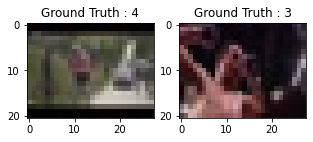

In [9]:
plt.figure(figsize=[5,5])

plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

### 5. Preprocesado de la data

#### Primero se normalizan las imágenes, para manejar, en todos los casos, números entre 0 y 1

In [10]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

#### Hacemos One-hot Encoding sobre el dataset, concretamente sobre la etiqueta

In [12]:
# Se cambian las etiquetas predictoras por la matriz resultante del One Hot Encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Se muestra este cambio
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0], "\n")


Original label: 4
After conversion to one-hot: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 



### 6. Creamos el Set de Entrenamiento y Validación

#### A partir del training set, ahora se reserva una parte del mismo para validar en cada epoch. Esto ayuda a la detección temprana del onverfitting, ya que el método "fit" nos informará del aprendizaje en entrenamiento y en validación en cada epoch, y si estos datos difieren mucho -empeorando mucho el de validación-, entonces el modelo probabemente esté sobreajustando a los datos de entrenamiento.

In [13]:
# Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [14]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(49361, 21, 28, 3) (12341, 21, 28, 3) (49361, 10) (12341, 10)


### 7. Creamos el modelo de red convolucional

#### Más abajo se muestra código para guardar el modelo entrenado y para cargarlo de memoria, cuando ya hemos ajustado el modelo lo suficiente para obtener un accuracy bueno

In [15]:
# declaramos variables con los parámetros de configuración de la red

INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001

epochs = 6 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento podríamos haber especificado un valor 
# de épocas más elevado y quizá haber generaro un callback de early_stop para evitar overfitting, pero por tratarse de un 
# ejercicio didáctico centrado en mostrar un diseño adecuado de red y en introducir algunas capas, como LeakyRelu, no se 
# ha hecho, para que el tiempo de entrenamiento no sea muy grande

batch_size = 64 # Cantidad de imágenes que se cargan a la vez en memoria. Como son imágenes pequeñas, puede especificarse 
# sin riesgo de saturar la memoria un valor de 64

In [ ]:
# 1.- LeakyRelu es una funcion de activacion, que evita el 0 de relu, pero se aplica como capa, por eso se le pone 
# activacion lineal a la capa convolucional, porque la activacion REAL tiene lugar aquí, el la capa LeakyRelu
# 2.- DropOut desactiva de forma aleatoria algunas neuronas de salida, lo que contribuye a evitar overfitting.
# 3.- Cuando aún así el modelo no ajusta bien, puede probarse limitando el DropOut a las capas densas de clasificación

sport_model = Sequential()

sport_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))
sport_model.add(LeakyReLU(alpha=0.1)) 
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))

sport_model.add(Conv2D(64, kernel_size=(3, 3),activation='linear'))
# LeakyRelu es una funcion de activacion, que evita el 0 de relu, pero se aplica como capa, por eso se le pone 
# activacion lineal a la capa convolucional, porque la activacion REAL tiene lugar aquí, el la capa LeakyRelu
sport_model.add(LeakyReLU(alpha=0.1)) 
sport_model.add(MaxPooling2D((2, 2)))
sport_model.add(Dropout(0.5))

sport_model.add(Conv2D(128, kernel_size=(3, 3),activation='linear'))
# LeakyRelu es una funcion de activacion, que evita el 0 de relu, pero se aplica como capa, por eso se le pone 
# activacion lineal a la capa convolucional, porque la activacion REAL tiene lugar aquí, el la capa LeakyRelu
sport_model.add(LeakyReLU(alpha=0.1)) 
sport_model.add(MaxPooling2D((2, 2)))
sport_model.add(Dropout(0.5))

sport_model.add(Flatten())
sport_model.add(Dense(32, activation='linear'))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(Dropout(0.5))
sport_model.add(Dense(nClasses, activation='softmax'))

In [ ]:
sport_model.summary()

In [ ]:
sport_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

#### Entrenamos el modelo: Aprende a clasificar imágenes

In [ ]:
# este paso puede tomar varios minutos, dependiendo de tu ordenador, cpu y memoria ram libre

sport_train = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

In [ ]:
test_loss, test_acc = sport_model.evaluate(valid_X,  valid_label)
print('\nTest accuracy:', test_acc)

#### Como el accuracy es bastante malo, diseñamos otra red diferente, con un enfoque distinto y mayor número de capas

In [18]:
# Aquí se introduce una capa nueva, que se llama BatchNormalization y que normaliza los datos de salida de la capa anterior.
# Esto optimiza el resultado, ya que evita que haya datos muy alejados entre sí, ubicándolos a todos entre el -1 y el 1.

# Explicación de capa BatchNormalization:
# 1.- Cuando normalizamos los datos solo la capa de entrada se beneficia de esto, conforme los datos pasan por otras capas ocultas 
# esta normalización se va perdiendo y si tenemos una red neuronal con muchas capas podemos tener problemas con el entrenamiento
# 2.- Este metodo tambien resuelve el problema **covariate shift**, si queremos entrenar correctamente una red neuronal 
# necesitamos que los datos estén bien distribuidos. En nuestra red neuronal tenemos las imágenes de los diferentes deportes, 
# y el método train_test_split, además de separar los conjuntos las mezcla, y además dividimos los datos de train en lotes más pequeños 
# -bath size-, es bueno que cada lote contenga imágenes de cada clase, si un lote solo contiene imagenes de una sola clase, el
# entrenamiento sera más lento y tendremos que elegir hiperparametros con más cuidado como el learning rate, este problema puede
# solucionarse si mezclamos los datos aleatoriamente (lo que hace por nosotros train_test_split) pero esto solo ayuda a la capa 
# de entrada. Por ello, lo que buscamos con BatchNormalization, es tener una distribución fija en cada neurona.

# Cuando estamos construyendo una ConvNet, esta capa puede sustituir a la de Pooling. En una FeedForward o DensNet,debería 
# situarse antes de cada activación

sport_model = Sequential()

sport_model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', strides=1, padding='same',input_shape=(21,28,3)))
sport_model.add(BatchNormalization())

sport_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same'))
sport_model.add(BatchNormalization())
sport_model.add(Dropout(0.25))

sport_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same'))
sport_model.add(MaxPooling2D(pool_size=(2, 2)))
sport_model.add(Dropout(0.25))

sport_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', strides=1, padding='same'))
sport_model.add(BatchNormalization())
sport_model.add(Dropout(0.25))

sport_model.add(Flatten())
sport_model.add(Dense(32, activation='linear'))
sport_model.add(LeakyReLU(alpha=0.2))
sport_model.add(BatchNormalization())
sport_model.add(Dropout(0.5))

sport_model.add(Dense(32, activation='linear'))
sport_model.add(LeakyReLU(alpha=0.2))
sport_model.add(BatchNormalization())
sport_model.add(Dropout(0.5))

sport_model.add(Dense(nClasses, activation='softmax'))

sport_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 21, 28, 64)        1792      
_________________________________________________________________
batch_normalization_5 (Batch (None, 21, 28, 64)        256       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 28, 64)        36928     
_________________________________________________________________
batch_normalization_6 (Batch (None, 21, 28, 64)        256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 21, 28, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 21, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 14, 64)       

In [ ]:
sport_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

sport_train = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

test_loss, test_acc = sport_model.evaluate(valid_X,  valid_label)
print('\Accuracy del set de validación:', test_acc)

In [20]:
# por último, vamos a tratar de mejorar un poco más el modelo, en este caso vamos a probar dos pasos más:
# a usar el optimizador "adam" al compilar (y entrenamos para comparar)
# y finalmente  si es necesario, entrenaremos con 30 epochs y callback de early_stop

# nos quedaremos con la mejor opción

#sport_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])
sport_model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

print ("Ya se ha compilado el modelo, ahora procedemos a su entrenamiento.\n");
sport_train = sport_model.fit(train_X, train_label, batch_size=batch_size, epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

test_loss, test_acc = sport_model.evaluate(valid_X,  valid_label)
print('\Accuracy del set de validación:', test_acc)


Ya se ha compilado el modelo, ahora procedemos a su entrenamiento.

Epoch 1/6
772/772 [==============================] - 784s 1s/step - loss: 0.5848 - accuracy: 0.8245 - val_loss: 0.0786 - val_accuracy: 0.9754
Epoch 2/6
772/772 [==============================] - 733s 949ms/step - loss: 0.1686 - accuracy: 0.9537 - val_loss: 0.0557 - val_accuracy: 0.9815
Epoch 3/6
772/772 [==============================] - 720s 933ms/step - loss: 0.1026 - accuracy: 0.9708 - val_loss: 0.0297 - val_accuracy: 0.9917
Epoch 4/6
772/772 [==============================] - 698s 905ms/step - loss: 0.0775 - accuracy: 0.9781 - val_loss: 0.1136 - val_accuracy: 0.9622
Epoch 5/6
772/772 [==============================] - 740s 958ms/step - loss: 0.0637 - accuracy: 0.9820 - val_loss: 0.0401 - val_accuracy: 0.9861
Epoch 6/6
386/386 [==============================] - 29s 76ms/step - loss: 0.0362 - accuracy: 0.9904
\Accuracy del set de validación: 0.9904384016990662


##### Puede observarse que en esta ocasión se ha conseguido un accuracy muy bueno tanto en entrenamiento como en validación, por lo que sospechamos que NO hay sobreajuste, dato que comprobaremos también con el dataset de test.


In [ ]:
# Este bloque de código muestra el history del entrenamiento, por lo que solo si has entrenado la red (y no si 
# la recuperas de disco) funcionará.

print (sport_train.history)
accuracy = sport_train.history['accuracy']
val_accuracy = sport_train.history['val_accuracy']
loss = sport_train.history['loss']
val_loss = sport_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### 8. Ahora se muestra el código que permite guardar y recuperar la red para no tener que volver a entrenarla

#### Primero se incorpora el código para guardar una red en disco

In [23]:
# obtenemos un accuracy bueno en validación, por lo que procedemos a continuar. Al clasificar con el conjunto de test,
# comprobaremos si ha habido sobreajuste o no 
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar

# sport_model.save("sports_mnist.h5py")
# serializa el modelo para JSON
model_json = sport_model.to_json()
with open("sport_model.json", "w") as json_file:
  json_file.write(model_json)
# serializan los pesos (weights) para HDF5
sport_model.save_weights("sport_model.h5")
print("Modelo guardado en el PC")


Modelo guardado en el PC


#### Ahora se muestra el código que la recupera del disco. Atención, porque hay que compilarla -no entrenarla-

In [16]:
# despues...
# carga el json y crea el modelo
json_file = open('sport_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

sport_model = keras.models.model_from_json(loaded_model_json)
# se cargan los pesos (weights) en el nuevo modelo
sport_model.load_weights("sport_model.h5")
print("Modelo cargado desde el PC.\n")
sport_model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
print("Modelo compilado.\n")

Modelo cargado desde el PC.

Modelo compilado.



### 9. Evaluamos la red

#### Puede comprobarse que con los datos de *TEST*, que hasta ahora no los ha visto la red, el accuracy sigue siendo muy bueno, por lo que definitivamente podemos afirmar que nuestro modelo no sobreajusta, ahora bien, todos los datos provienen del mismo conjunto y se han obtenido en su mayoría a partir de secuencias de vídeo. Esto quiere decir que guardan una inmensa similutud. 

#### ¿Podría originar esto añgun tipo de sesgo o "vicio" en la capacidad clasificadora de la red? Lo veremos más abajo, en una segunda fase de test, con imágenes totalmente diferentes.

In [17]:

test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)

483/483 [==============================] - 35s 73ms/step - loss: 0.0301 - accuracy: 0.9921


In [18]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.030141238123178482
Test accuracy: 0.9920912981033325


In [19]:
predicted_classes2 = sport_model.predict(test_X)

In [20]:
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)

In [21]:
predicted_classes.shape, test_Y.shape

((15426,), (15426,))

### 10. Aprendamos de los errores: Qué mejorar

In [23]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(test_Y, predicted_classes)

print(matrix)

[[1874    0    0    0    0    0    0    5    0    0]
 [   5 1825    0    0    0    1    0    0    0    0]
 [   4    0 1544    0    0    0    0    4    0    0]
 [   0    0    0 1415    1    0    0    0    0    0]
 [   0    0    0    0 1479    0    3    0    0    0]
 [   0    0    0    0    0 1003    0    0    0    0]
 [   8    0    0    0    0    0 1434   87    0    0]
 [   2    1    0    0    0    1    0 1891    0    0]
 [   0    0    0    0    0    0    0    0 1040    0]
 [   0    0    0    0    0    0    0    0    0 1799]]


En test hemos clasificado bien  15303 imágenes


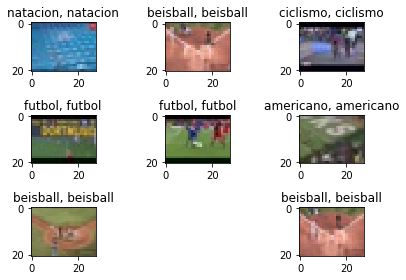

In [37]:
correct = np.where(predicted_classes==test_Y)[0]
print("En test hemos clasificado bien  %d imágenes" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[correct]],
                                                    deportes[test_Y[correct]]))

    plt.tight_layout()

En test hemos clasificado de forma incorrecta 123 imágenes


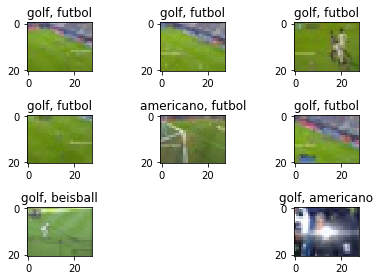

In [35]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("En test hemos clasificado de forma incorrecta %d imágenes" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[incorrect]],
                                                    deportes[test_Y[incorrect]]))
    plt.tight_layout()

In [33]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.98      1.00      0.99      1955
     Class 1       1.00      1.00      1.00      1841
     Class 2       1.00      0.99      1.00      1560
     Class 3       1.00      1.00      1.00      1398
     Class 4       1.00      1.00      1.00      1491
     Class 5       1.00      1.00      1.00      1032
     Class 6       1.00      0.94      0.97      1508
     Class 7       0.96      0.99      0.98      1926
     Class 8       1.00      1.00      1.00      1012
     Class 9       1.00      1.00      1.00      1703

    accuracy                           0.99     15426
   macro avg       0.99      0.99      0.99     15426
weighted avg       0.99      0.99      0.99     15426



### 11. Clasificación de imágenes nuevas

#### A continuación se facilitsa código para que puedas testear el modelo con imágenes de deportes de las que tú dispongas y compruebes su capacidad de clasificación real.

#### El resize se hace por código, para automatizar el proceso, por lo que no tienes que molestarte en cambiar el tamaño y puedes emplear cualquier imagen de la que dispongas

#### Se puede observar que sobre estas otras imágenes el ratio de aciertos baja de forma drástica (¡¡por debajo del 40%!!). 

Esto se debe probablemente a que las imágenes de entrenamiento, de validación y test se han tomado de secuencias de vídeos en su gran mayoría (por lo que guardan una gran similitud). También es muy posible que influya que el tamaño (21x28) es muy pequeño para analizar detalles que diferencian a unos deportes y otros (quizá se confunde cuando hay mucho verde, o cuando hay varias personas y no se puede diferenciar, por la imagen, qué hacen las personas). 

#### Aún así el ejercicio resulta muy interesante a nivel didáctico. Con imágenes de mayor tamaño las necesidades de computación en entrenamiento se dispararían. 

In [38]:
from skimage.transform import resize

images=[]

filenames = ['pruebasPosteriores\\ame1.jpg','pruebasPosteriores\\ame2.jpg','pruebasPosteriores\\bo1.jpg','pruebasPosteriores\\bo2.jpg','pruebasPosteriores\\f11.jpg','pruebasPosteriores\\f12.jpg','pruebasPosteriores\\fu1.jpg','pruebasPosteriores\\fu2.jpg','pruebasPosteriores\\go1.jpg','pruebasPosteriores\\go2.jpg','pruebasPosteriores\\na1.jpg','pruebasPosteriores\\na2.jpg','pruebasPosteriores\\na3.jpg']

for filepath in filenames:
    print(filepath,"\n")
    image = plt.imread(filepath,0)
    image_resized = resize(image, (21, 28),anti_aliasing=True,clip=False,preserve_range=True)
    images.append(image_resized)
    #images.append(image)

X = np.array(images, dtype=np.uint8) #convierto de lista a numpy
test_X = X.astype('float32')
test_X = test_X / 255.

predicted_classes = sport_model.predict(test_X)

for i, img_tagged in enumerate(predicted_classes):
    print(filenames[i], deportes[img_tagged.tolist().index(max(img_tagged))])

pruebasPosteriores\ame1.jpg 

pruebasPosteriores\ame2.jpg 

pruebasPosteriores\bo1.jpg 

pruebasPosteriores\bo2.jpg 

pruebasPosteriores\f11.jpg 

pruebasPosteriores\f12.jpg 

pruebasPosteriores\fu1.jpg 

pruebasPosteriores\fu2.jpg 

pruebasPosteriores\go1.jpg 

pruebasPosteriores\go2.jpg 

pruebasPosteriores\na1.jpg 

pruebasPosteriores\na2.jpg 

pruebasPosteriores\na3.jpg 

pruebasPosteriores\ame1.jpg golf
pruebasPosteriores\ame2.jpg americano
pruebasPosteriores\bo1.jpg boxeo
pruebasPosteriores\bo2.jpg boxeo
pruebasPosteriores\f11.jpg americano
pruebasPosteriores\f12.jpg americano
pruebasPosteriores\fu1.jpg boxeo
pruebasPosteriores\fu2.jpg golf
pruebasPosteriores\go1.jpg golf
pruebasPosteriores\go2.jpg golf
pruebasPosteriores\na1.jpg golf
pruebasPosteriores\na2.jpg golf
pruebasPosteriores\na3.jpg golf
